# Bayesian Networks - an exemplary study

### This notebook has differing results from the final paper as it has been rerun since. We present more the methodology of our locality weather model.

This notebook is designed for Python 3.5 and Mac OS X

In [1]:
%matplotlib inline
import datascrape as ds
from datetime import date
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import product
sns.set_style('whitegrid')

/Users/charlesliu/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df = pd.read_csv('data/KBOS-2012.csv')

In [3]:
df.columns

Index(['EST', 'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       ' Mean Humidity', ' Min Humidity', ' Max Sea Level PressureIn',
       ' Mean Sea Level PressureIn', ' Min Sea Level PressureIn',
       ' Max VisibilityMiles', ' Mean VisibilityMiles', ' Min VisibilityMiles',
       ' Max Wind SpeedMPH', ' Mean Wind SpeedMPH', ' Max Gust SpeedMPH',
       'PrecipitationIn', ' CloudCover', ' Events', ' WindDirDegrees'],
      dtype='object')

In [4]:
# All data
dd = ds.dictdf(ds.munis, date(1960, 1, 1), date(2015, 12, 31))

## 1. Preprocessing the data
We quantize the measured precipitation in inches into the following buckets:

0 - 0.02 (No rain)

0.02 - 0.065

0.065 - 0.15

0.15 - 0.3

0.3 - 0.6

\> 0.6

In [5]:
num_measurements = len(dd["KBOS"])
rain_measurements = np.zeros(num_measurements*len(dd))
for ii, muni in enumerate(dd):
    rain_measurements[ii*num_measurements:(ii+1)*num_measurements] = dd[muni].PrecipitationIn.values

[0, 3, 0, 60987.0]

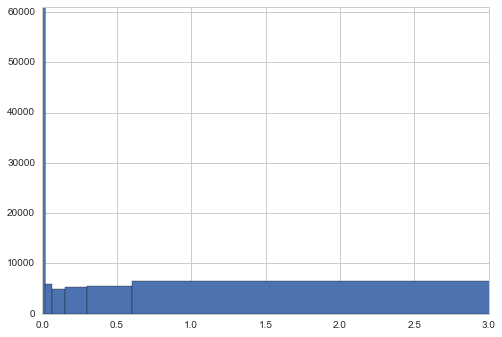

In [6]:
# hardcode bins to make each bin roughly equal in size
bins = [0.0, 0.02, 0.065, .15, .3, .6, 200]
n, bins, patches = plt.hist(rain_measurements, bins=bins)
plt.axis([0, 3, 0, max(n)])

In [7]:
# get dictionary from muni -> df to just muni -> rain measurements and muni -> discrete levels
rain_discrete = {}
rain_measure = {}
for muni in dd:
    rain_measure[muni] = dd[muni].PrecipitationIn.values
    rain_discrete[muni] = np.digitize(dd[muni].PrecipitationIn.values, bins)

## 2. Learning the network structure
For learning the network structure many algorithms exist. Since the problem of learning a structure is NP-hard, usually greedy algorithms are used. For this project we use the K2 algorithm with a node preordering to further speed up the learning process.

### 2.1 Ordering of stations (nodes)
In order to compute a dependency DAG between stations, we need for the K2 algorithm a (preliminary) (topological) ordering of the stations. To obtain this via an automated process (Note that for an in-depth weather model dependencies should be picked carefully manually and change over the time to adapt to global metereological changes) we use a combination of a Minimum Spanning Tree (MST) and Breadth First Search (BFS) on it to obtain a valid ordering.

In [8]:
# Attention!
# The following code needs the mpl_toolkits for Matlab installed to run
# and output the map visualizations
# To install for Mac OS X do:
#
# 1. run `brew install geos`
# 2. then get tarball from http://matplotlib.org/basemap/users/installing.html (~100MB download)
# 3. run `python3 setup.py install` from basemap directory

# make sure these are working
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

In [9]:
# helper function to plot the region around the stations out
def plot_MA_map(water_color=sns.xkcd_rgb["baby blue"], \
    land_color=sns.xkcd_rgb["beige"], \
    marker_color=sns.xkcd_rgb["chocolate brown"], \
    arrow_color=sns.xkcd_rgb["dull red"]):

    map = Basemap(llcrnrlon=-74.5,llcrnrlat=40.75,urcrnrlon=-69.75,urcrnrlat=43, resolution = 'h')
    map.drawstates(color='white', linewidth=2)
    map.drawmapboundary(fill_color=water_color)
    map.fillcontinents(color=land_color,lake_color=water_color)
    map.drawrivers(color=water_color, zorder=-1)
    
    return map

We estimate the ordering via a minimum spanning tree (MST) based on euclidean distance (here incorrectly lon/lat are used - due to the small relative scale this is feasible still). The estimation is done by using scipy's new graph features (you need version 0.11 to run it). To speedup the computation we do not relie on the complete graph to compute a MST but build instead a preliminary graph using k-nearest neighbor search (here with 6 neighbors).

In [10]:
# load lon/lat data and join with station names
dfgeo = pd.read_csv('data/geoinfo.tsv', sep='\t')
dfgeo.set_index('name', inplace=True)
dfmunis = pd.DataFrame(list(ds.munis.items()), columns=['code', 'name'])
dfmunis.set_index('name', inplace=True)

dfjoined = dfmunis.join(dfgeo)
dfjoined.reset_index(inplace=True)
dfjoined.head(20)

,name,code,lat,lon
0,Newport,KUUU,41.49,71.31
1,Purchase,KHPN,41.04,73.71
2,Bedford,KBED,42.47,71.28
3,Chicopee,KCEF,42.20,72.53
4,Lawrence,KLWM,42.72,71.12
5,Pittsfield,KPSF,42.26,73.18
6,New York,KNYC,40.77,73.98
7,Albany,KALB,42.75,73.80
8,Providence,KPVD,41.73,71.43
9,Worcester,KORH,42.27,71.87


In [11]:
# produce ordering using a minimum spanning tree based on distance as edge weights
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import minimum_spanning_tree

X = dfjoined[['lon', 'lat']].values
# use 6 nearest neighbors to generate preliminary graph
G = kneighbors_graph(X, n_neighbors=6, mode='distance')
# compute the minimum spanning tree of this graph
T = minimum_spanning_tree(G, overwrite=True)
# retrieve coordinates
T = T.tocoo()

dist = T.data
p1 = T.row
p2 = T.col
A = X[p1].T
B = X[p2].T
lon_coords = np.vstack([A[0], B[0]])
lat_coords = np.vstack([A[1], B[1]])

The following code produces a nice image of the minimum spanning tree obtained via Kruskal's algorithm above:

In [12]:
def plot_map_mst(map, lon_coords, lat_coords, marker_color=sns.xkcd_rgb["chocolate brown"], \
    arrow_color=sns.xkcd_rgb["dull red"]):
    
    def plot_mst(map, lon_coords, lat_coords):
        assert(lon_coords.shape == lat_coords.shape)
        coeff_cut = 0.06
        for i in range(lon_coords.shape[1]):
            lons = -np.array([lon_coords[0, i], lon_coords[1, i]])
            lats = np.array([lat_coords[0, i], lat_coords[1, i]])

            x, y = map(lons, lats)

            dx = x[1] - x[0]
            dy = y[1] - y[0]
            plt.arrow(x[0] + coeff_cut * 0.5 * dx, y[0] + coeff_cut * 0.5 * dy, \
                      (1.0 - coeff_cut)* dx, (1.0 - coeff_cut) * dy,\
                      shape='full', lw=1.35, length_includes_head=True, head_width=.0,\
                      fc=arrow_color, ec=arrow_color, zorder=25)

    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    for label, xpt, ypt in zip(labels, x, y):
        #manual positioning fix
        if label == 'Westfield':
            plt.text(xpt+2*offset, ypt-3*offset, label, zorder=30)
        else:  
            plt.text(xpt+offset, ypt+offset, label,zorder=30)
    plot_mst(map, lon_coords, lat_coords)

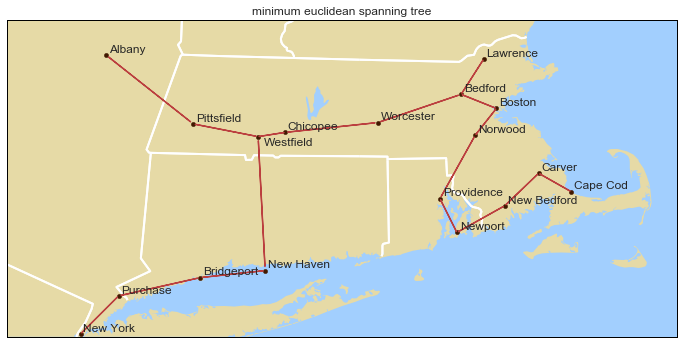

In [13]:
plt.figure(figsize=(12, 7))
euc_map = plot_MA_map()
plot_map_mst(euc_map, lon_coords, lat_coords)
plt.title('minimum euclidean spanning tree')

We now infer a topological ordering via BFS. It is up to the user to pick a meaningful start node (probably a node with many children).

In [14]:
from enum import Enum

adj_matrix = T.toarray()

class Color(Enum):
    GRAY = 1 # next to visit
    WHITE = 0 # non-visited
    BLACK = 2 # visited
# determine an ordering from a MST via some tree search (choose BFS here)
num_nodes = adj_matrix.shape[0]
colors = np.array([Color.WHITE] * num_nodes)
# some start node (here the first one --> let the user choose this one)
start_node = 0
order = []
colors[start_node] = Color.GRAY
order.append(start_node) # whenever something is GRAYED add to order...
queue = []
queue.append(start_node)
while len(queue) > 0:
    #dequeue
    u = queue[0]
    queue = queue[1:]
    
    for v in range(num_nodes):
        #adjacent ?
        if adj_matrix[u, v] > 0 or adj_matrix[v, u] > 0:
            if colors[v] == Color.WHITE: # not visited yet?
                colors[v] = Color.GRAY
                order.append(v)
                queue.append(v)
    colors[u] = Color.BLACK

In [15]:
# the obtained order
order

[0, 8, 10, 14, 17, 11, 12, 2, 4, 9, 3, 13, 5, 16, 7, 15, 1, 6]

In [16]:
# helper function to visualize the order onto a map
def plot_map_order(map, order, marker_color=sns.xkcd_rgb["chocolate brown"]):
    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    pos = 1
    for i in order:
        label, xpt, ypt = labels[i], x[i], y[i]
        #manual positioning fix
        if label == 'Westfield':
            label = ''
            plt.text(xpt+2*offset, ypt-3*offset, label + ' ({})'.format(pos), zorder=30, fontsize=16)
        else:  
            label = ''
            plt.text(xpt+offset, ypt+offset, label + ' ({})'.format(pos),zorder=30, fontsize=16)
        pos += 1

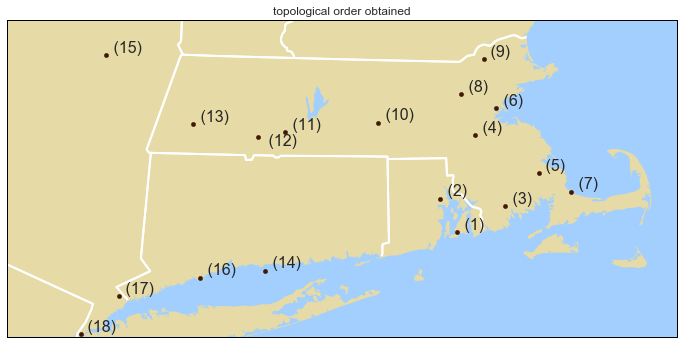

In [17]:
plt.figure(figsize=(12, 7))
top_map = plot_MA_map()
plot_map_order(top_map, order)
plt.title('topological order obtained')

In [18]:
# convert ordering to station codes
node_ordering = []
key_vals = list(ds.munis.keys())
for idx in order:
    node_ordering.append( key_vals[idx])

In [19]:
# current ordering
node_ordering

['KUUU',
 'KPVD',
 'KEWB',
 'KOWD',
 'KPYM',
 'KBOS',
 'KFMH',
 'KBED',
 'KLWM',
 'KORH',
 'KCEF',
 'KBAF',
 'KPSF',
 'KHVN',
 'KALB',
 'KBDR',
 'KHPN',
 'KNYC']

In [20]:
ord_relation ={}
for i in range(len(node_ordering) - 1):
    ord_relation[node_ordering[i+1]] = [node_ordering[i]]
ord_relation

{'KALB': ['KHVN'],
 'KBAF': ['KCEF'],
 'KBDR': ['KALB'],
 'KBED': ['KFMH'],
 'KBOS': ['KPYM'],
 'KCEF': ['KORH'],
 'KEWB': ['KPVD'],
 'KFMH': ['KBOS'],
 'KHPN': ['KBDR'],
 'KHVN': ['KPSF'],
 'KLWM': ['KBED'],
 'KNYC': ['KHPN'],
 'KORH': ['KLWM'],
 'KOWD': ['KEWB'],
 'KPSF': ['KBAF'],
 'KPVD': ['KUUU'],
 'KPYM': ['KOWD']}

### 2.2 Bayesian Network With K2


We first run a modified version of the K2 algorithm given our node ordering. It is a greedy algorithm that for a given node, selects parents from the nodes preceding it in the ordering that maximizes the probability at every step

In [21]:
# helper function to increment counter in dict
def inc(dic, key):
    if key in dic:
        dic[key] += 1
    else:
        dic[key] = 1
        
# helper function to get conditional probability
def conditional_prob(muni, muni_bucket, parents):
    parents_count = 1
    parents_muni_count = 1
    for i in range(num_measurements):
        parents_row = True
        for parent, bucket in parents.items():
            if rain_discrete[parent][i] != bucket:
                parents_row = False
                break
        if parents_row:
            parents_count += 1
            if rain_discrete[muni][i] == muni_bucket:
                parents_muni_count += 1
    return parents_muni_count/parents_count

# helper function to get conditional distribution
def conditional_dist(muni, parents):
    p = np.zeros(len(bins))
    for i in range(num_measurements):
        parents_row = True
        for parent, bucket in parents.items():
            if rain_discrete[parent][i] != bucket:
                parents_row = False
                break
        if parents_row:
            p[rain_discrete[muni][i]-1] += 1
    return p/np.sum(p)
        
# helper function for k2, calculate probability of some municipality and list of parents
def log_probability(muni, parents):
    p = 0
    discrete_counts = {}
    for i in range(num_measurements):
        key = []
        for parent in parents:
            key.append(rain_discrete[parent][i])
        key = tuple(key)
        key2 = rain_discrete[muni][i]
        if key in discrete_counts:
            inc(discrete_counts[key], key2)
        else:
            discrete_counts[key] = {key2: 1}
            
    for permutation in discrete_counts:
        total_instances = 0
        for k in range(1, len(bins)):
            if k in discrete_counts[permutation]:
                instances = discrete_counts[permutation][k]
                total_instances += instances
                p += np.sum(list(map(lambda x: np.log(x), range(1, instances))))
        p += np.sum(list(map(lambda x: np.log(x), range(1, len(bins) - 1))))
        p -= np.sum(list(map(lambda x: np.log(x), range(1, total_instances + len(bins) - 1))))
    return p

# helper function to calculate total log probability
def BayesNetLog(adjacency_dict):
    p = 0
    for muni, parents in adjacency_dict.items():
        p += log_probability(muni, parents)
    return p

# k2 algorithm
def k2(node_ordering, max_parents):
    adjacency_dict = {}
    # keep track of munis we've come across to avoid cycles
    visited_munis = set()
    for muni in node_ordering:
        parents = []
        p_old = log_probability(muni, parents)
        keepGoing = True
        while keepGoing and len(parents) < max_parents:
            # greedily choose the next neighbor to add calculating log_probability
            # from adding a neighbor that hasn't been visited yet
            p_best = -np.inf
            best_neighbor = None
            neighbors = visited_munis - set(parents)
            if len(neighbors) > 0:
                neighbors = list(map(lambda x: (x, log_probability(muni, parents + [x])), neighbors))
                best_neighbor, p_best = max(neighbors, key=lambda x: x[1])
            if p_best > p_old:
                p_old = p_best
                parents = parents + [best_neighbor]
            else:
                keepGoing = False
        adjacency_dict[muni] = parents
        visited_munis.add(muni)
    return adjacency_dict

In [22]:
# run k2 algorithm with maximum 3 parents per node
k2_max3 = k2(node_ordering, 3)

In [23]:
k2_max3

{'KALB': ['KPSF', 'KCEF'],
 'KBAF': ['KORH', 'KOWD'],
 'KBDR': ['KPVD', 'KHVN'],
 'KBED': ['KOWD', 'KBOS'],
 'KBOS': ['KPVD', 'KOWD'],
 'KCEF': ['KORH'],
 'KEWB': ['KUUU', 'KPVD'],
 'KFMH': ['KEWB'],
 'KHPN': ['KBDR'],
 'KHVN': ['KPVD'],
 'KLWM': ['KBOS', 'KBED'],
 'KNYC': ['KBDR', 'KHPN'],
 'KORH': ['KBOS', 'KBED'],
 'KOWD': ['KEWB'],
 'KPSF': ['KBAF'],
 'KPVD': ['KUUU'],
 'KPYM': ['KEWB', 'KUUU'],
 'KUUU': []}

### 2.3 Simulated Annealing on K2 Result

As K2 is a greedy algorithm, there is no guarantee for optimality. We run simulated annealing to see if we can find any improvement beyond it.

In [24]:
node_idx = dict(zip(node_ordering, range(len(node_ordering))))
idx_node = dict(zip(range(len(node_ordering)), node_ordering))
switchable_nodes = node_ordering[1:]
# create algorithm to randomly reassign dependencies
def reassign_deps(adjacency_dict, num_parents):
    rand_muni = np.random.choice(switchable_nodes)
    rand_parents = list(map(lambda x: idx_node[x], np.random.choice(range(node_idx[rand_muni]), \
                            size=min(num_parents,node_idx[rand_muni]), replace=False)))
    adjacency_dict[rand_muni] = rand_parents
    return adjacency_dict

In [50]:
temperature = 10.0
#start with resulting adjacency from k2
adj_mat = k2_max3
best_found = BayesNetLog(adj_mat)
best_mat = dict(adj_mat)
err_trace = [best_found]
prev_E = best_found
m = 1000
ftol = 0.01

In [51]:
for i in range(10000):
    # swaps for new corr matrix
    num_swaps = np.max([1,np.random.choice(np.floor(np.sqrt(temperature)).astype(int))])
    new_adj_mat = reassign_deps(adj_mat, num_swaps)
    new_E = BayesNetLog(new_adj_mat)
    deltaE  =  new_E - prev_E
    # update check, deltas are extremely high so modify probability of accepting
    if deltaE > 0 or np.random.rand() < np.exp( -np.log(-deltaE)/temperature):
        if best_found < new_E:
            best_found = new_E
            best_mat = dict(new_adj_mat)
        adj_mat = new_adj_mat
        prev_E = new_E
        err_trace.append(new_E)
    
    if len(err_trace) % 100 == 0:
        temperature *= 0.9
        if temperature < 1.0:
            temperature = 1.0
    
    if len(err_trace) > m and np.std(err_trace[-m:])/np.mean(err_trace[-m:]) < ftol:
        break

Note: This is run-dependent as not only is the node ordering different on a given run but obviously SA is as well. We have found instances where SA returned no improvement. We've also played around with how likely of accepting a worse position, these K2 solutions seem to be part of a local minimum that's quite difficult in some cases.

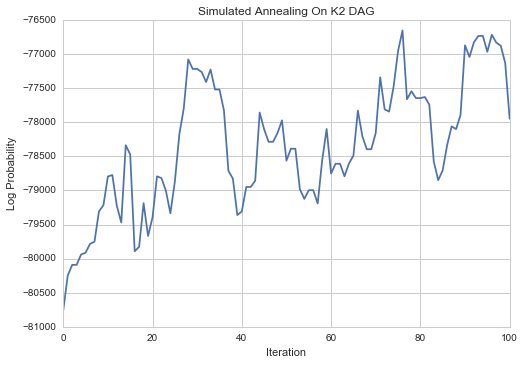

In [52]:
plt.xlabel("Iteration")
plt.ylabel("Log Probability")
plt.title("Simulated Annealing On K2 DAG")
plt.plot(err_trace)

In [43]:
best_mat

{'KALB': ['KPSF', 'KCEF'],
 'KBAF': ['KORH', 'KOWD'],
 'KBDR': ['KPVD', 'KHVN'],
 'KBED': ['KOWD', 'KBOS'],
 'KBOS': ['KPVD', 'KOWD'],
 'KCEF': ['KORH'],
 'KEWB': ['KUUU', 'KPVD'],
 'KFMH': ['KEWB'],
 'KHPN': ['KBDR'],
 'KHVN': ['KPVD'],
 'KLWM': ['KBOS', 'KBED'],
 'KNYC': ['KBDR', 'KHPN'],
 'KORH': ['KBOS', 'KBED'],
 'KOWD': ['KEWB'],
 'KPSF': ['KBAF'],
 'KPVD': ['KUUU'],
 'KPYM': ['KEWB', 'KUUU'],
 'KUUU': []}

### 2.4 Plotting a estimated dependency relation via K2+SA algorithm
In order to verify that the network structured obtained via our approach makes sense, visual inspection is critical.

In [28]:
# relation is a dict with child : [parent1, parent2]
# arrows are from parents to child
def plot_map_graph(map, relation, \
    marker_color=sns.xkcd_rgb["chocolate brown"], \
    arrow_color=sns.xkcd_rgb["dull red"]):
    
    def plot_graph(map, relation):
        for child_code, parents in relation.items():
            child = dfjoined[dfjoined['code'] == child_code]
            parent = None
            for parent_code in parents:
                parent = dfjoined[dfjoined['code'] == parent_code]
                
                lons = -np.array(list(parent['lon']) + list(child['lon']))
                lats = np.array(list(parent['lat']) + list(child['lat']))

                x, y = map(lons, lats)

                dx = x[1] - x[0]
                dy = y[1] - y[0]
                plt.arrow(x[0] + coeff_cut * 0.5 * dx, y[0] + coeff_cut * 0.5 * dy, \
                          (1.0 - coeff_cut)* dx, (1.0 - coeff_cut) * dy,\
                          shape='full', lw=1.35, length_includes_head=True, head_width=.04,\
                          fc=arrow_color, ec=arrow_color, zorder=25)

    lons = -dfjoined.lon.values
    lats = dfjoined.lat.values

    x, y = map(lons, lats)

    map.scatter(x, y, marker='o',color=marker_color, zorder=10)
    labels = dfjoined.name
    offset = 0.02
    for label, xpt, ypt in zip(labels, x, y):
        #manual positioning fix
        if label == 'Westfield':
            plt.text(xpt+2*offset, ypt-3*offset, label, zorder=30)
        else:  
            plt.text(xpt+offset, ypt+offset, label,zorder=30)

    coeff_cut = 0.06
    
    plot_graph(map, relation)


Hence, let's first plot the node ordering we are actually using for the K2 algorithm

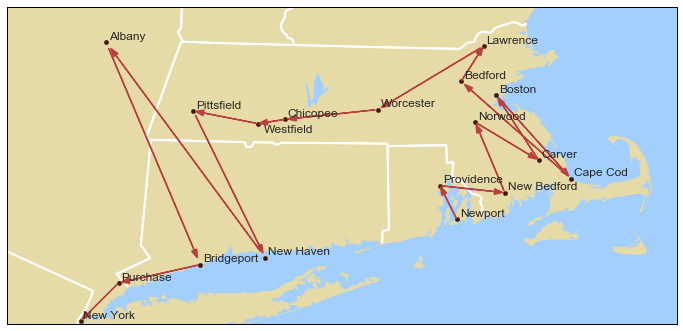

In [29]:
plt.figure(figsize=(12, 7))
node_map = plot_MA_map()
plot_map_graph(node_map, ord_relation)

In a second step, we compare then the final dependecy structure the K2 learning algorithm yielded.

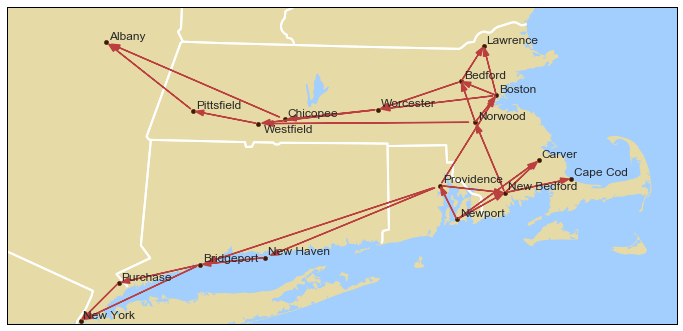

In [30]:
# this plots out the dependency
plt.figure(figsize=(12, 7))
dep_map = plot_MA_map()
plot_map_graph(dep_map, best_mat)

## 3. Inference

### 3.1 Direct Sampling

Use rejection sampling via empirical distributions from samples going down the node ordering,
We draw random samples given empirical distributions, then for rejection sampling we want to infer a region's precipitation data from the actual historical precipitation data of it's parents in the network

In [31]:
# create a mapping from node to node ordering
node_idx = dict(zip(node_ordering, range(len(node_ordering))))
# use previous conditional_dist(muni, parents) function for conditional probabilities
# starting from head node of ordering and going down the dependency
def direct_sample(num_samples):
    assignments = np.zeros((num_samples, len(node_ordering)), dtype=int)
    for sample in range(num_samples):
        for node in node_ordering:
            parents = {}
            for parent in best_mat[node]:
                parents[parent] = assignments[sample, node_idx[parent]]
            assignments[sample, node_idx[node]] = np.random.choice(len(bins), p=conditional_dist(node, parents)) + 1
    return assignments

# use sample function to get dependencies of a muni
# rejection sampling from actual parent data
def rejection_sample(muni, num_samples):
    num_samples = min(num_samples, len(rain_discrete[muni]))
    samples = np.zeros(num_samples, dtype=int)
    parents = best_mat[muni]
    base_p = conditional_dist(muni, {})
    for iteration in range(num_samples):
        rej_samples = direct_sample(100)
        p = np.array(base_p)
        for sample in rej_samples:
            all_satisfied = True
            for parent in parents:
                if rain_discrete[parent][iteration] != sample[node_idx[parent]]:
                    all_satisfied = False
                    break
            if all_satisfied:
                p[sample[node_idx[muni]]-1] += 1
        p /= np.sum(p)
        samples[iteration] = np.random.choice(len(bins), p=p) + 1
    return samples

We draw 100 samples for Boston, and compare to the actual first 100 days of Boston precipitation

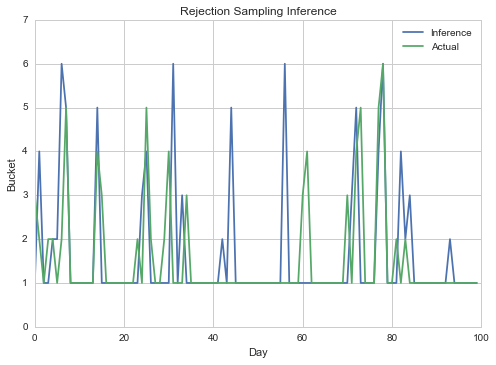

In [32]:
samples = rejection_sample("KBOS", 100)
plt.ylim([0, 7])
plt.plot(samples, label="Inference")
plt.plot(rain_discrete["KBOS"][0:100], label="Actual")
plt.xlabel("Day")
plt.ylabel("Bucket")
plt.title("Rejection Sampling Inference")
plt.legend()
#plt.savefig("images/rej_samp.png", dpi=250)

### 3.2 Gibbs Sampling
Naturally, the structure of a Bayesian network favors Gibbs sampling. Thus in order to generate valid samples, we pick a random node and then sample it according to the distribution obtained by conditioning on its parents. Repeating this process will finally converge to a valid distribution.

In [33]:
# helper func to retrieve the
# markov blanket of X_i, i.e. the set of all X_i's children, their parents and X_i's parents
# layout of adj_mat as dict is child : [list of parents]
def markov_blanket(code, adj_mat):
    mb = []
    children = []
    # get children of code
    for child, parents in adj_mat.items():
        if code in parents:
            children.append(child)
    # append all parents of children
    for child in children:
        mb.append(child)
        mb += adj_mat[child]
    
    mb += adj_mat[code] # parents of code
    
    # remove duplicates + node itself
    return list(set(mb) - set([code]))

In [34]:
# Gibbs sampler for bayesian net
# we sample by drawing for the currently picked node X_i a sample according to P(X_i | mb(X_i)) where mb(X_i) is the
# markov blanket of X_i, i.e. the set of all X_i's children, their parents and X_i's parents
def gibbs_sampler(adj_mat, num_steps=1000):
    key_vals = list(ds.munis.keys())
    num_nodes = len(key_vals)

    X = np.random.randint(len(bins), size=num_nodes) + 1 # init to no rain

    trace = np.zeros((num_steps, num_nodes) )
    for step in range(num_steps):
        Xnew = X.copy()
        # choose random code
        code = key_vals[np.random.randint(len(key_vals))]

        # construct condition
        cond_variables = {}
        mb = markov_blanket(code, adj_mat)
        for key in mb:
            cond_variables[key] = X[key_vals.index(key)]

        # get conditional probabilities
        cond_probabilities = np.zeros(len(bins))
        i = 0
        for val in range(1, len(bins) + 1):
            cond_probabilities[i] = conditional_prob(code, val, cond_variables) 
            i += 1
        # normalize prob to account for numerical problems
        cond_probabilities /= np.sum(cond_probabilities)

        # cumsum sampling method
        cum_probs = np.cumsum(cond_probabilities)
        u = np.random.uniform()
        # udpdate sample
        sample = np.sum((cum_probs < u) * 1) + 1
        Xnew[key_vals.index(code)] = sample
        X = Xnew.copy()
        trace[step, :] = Xnew
        
        if step % 100 == 0 and step > 0:
            print('{:6d}/{:6d} iterations...'.format(step, num_steps))
    print('{:6d}/{:6d} iterations...'.format(num_steps, num_steps))
    return trace, key_vals

In [35]:
%%time
trace, key_vals = gibbs_sampler(best_mat, 2000)

   100/  2000 iterations...
   200/  2000 iterations...
   300/  2000 iterations...
   400/  2000 iterations...
   500/  2000 iterations...
   600/  2000 iterations...
   700/  2000 iterations...
   800/  2000 iterations...
   900/  2000 iterations...
  1000/  2000 iterations...
  1100/  2000 iterations...
  1200/  2000 iterations...
  1300/  2000 iterations...
  1400/  2000 iterations...
  1500/  2000 iterations...
  1600/  2000 iterations...
  1700/  2000 iterations...
  1800/  2000 iterations...
  1900/  2000 iterations...
  2000/  2000 iterations...
CPU times: user 34.4 s, sys: 24.1 ms, total: 34.5 s
Wall time: 34.5 s


We now specifically look at Boston and compare the samples to some historical data we have. As the sampler needs some time till it converges, we use a burn-in rate of 1000 samples which is roughly 3 years which is due to our skewed distribution.

In [36]:
code = 'KBOS'
idx_bos = key_vals.index(code)
tr_bos = trace[:, idx_bos]
burnin = 600

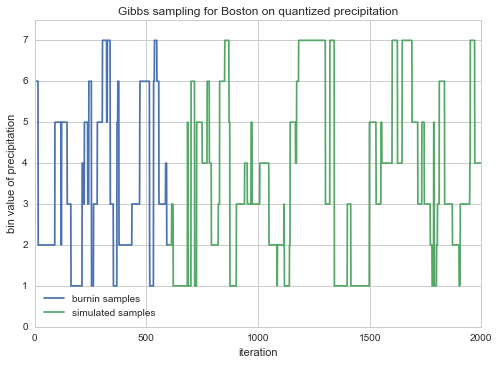

In [37]:
plt.plot(np.arange(burnin), tr_bos[:burnin], label='burnin samples')
plt.plot(burnin + np.arange(tr_bos.shape[0] - burnin), tr_bos[burnin:], label='simulated samples')
plt.legend(loc='best')
plt.ylim(0, 7.5)
plt.xlabel('iteration')
plt.ylabel('bin value of precipitation')
plt.title('Gibbs sampling for Boston on quantized precipitation')
#plt.savefig('images/gibbs.png', dpi=120)

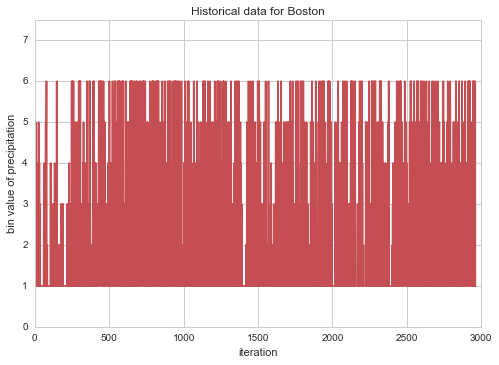

In [38]:
plt.plot(rain_discrete[code][:-tr_bos.shape[0]], color=sns.color_palette()[2])
plt.ylim(0, 7.5)
plt.xlabel('iteration')
plt.ylabel('bin value of precipitation')
plt.title('Historical data for Boston')
#plt.savefig('images/boshist.png', dpi=120)

Comparing the results we see that the plots are not really similar. This is mainly due to our very reduced set of variables. Since weather is very complex to model, more data should help this approach to work as it has been successfully applied in the literature.

#### 3.2.1 Test for "Convergence"
Adapting the code from the homework we now perform a test of whether the sampler has converged or not via the Geweke test:

In [39]:
# From HW2 AM207

# rhot function calculates the auto-correlation coefficient of the former and latter chunk of x
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# Geweke function that tests convergence
def Geweke(trace, intervals, length):
    nsl=length
    # jump is the each chunk size
    jump = int(0.9*len(trace)/(2*intervals))
    # Geweke starts calculating from 10% of total length, and this is to cut-off the burn-in part
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # loop to make 'interval' number of chunks 
    for k in np.arange(0, intervals):
        # the early segment starting point
        baga = np.int(first+k*jump)
        # the latter segement starting point
        bagb = int(len(trace)/2 + k*jump)
        
        # sub trace segements extraction
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # compute the means of each segement
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # this is to cut-off the burn-in part of each chunk (we assume early 10% data as burn-in)
        for i in range(int(0.1*nsl)):
            # sum up auto-correlation coefficient to compute Effective Sample Size later
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # compute variance with considering Effective Sample Size
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # compute the z-score to see if our chain converges
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z

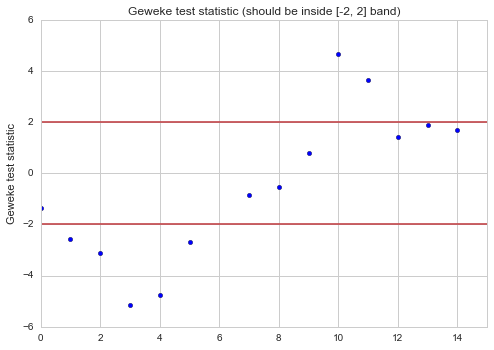

In [40]:
pts = Geweke(tr_bos[burnin*2:], 15, 80)
plt.scatter(np.arange(pts.shape[0]), pts*1.)
plt.title('Geweke test statistic (should be inside [-2, 2] band)')
plt.plot([0, pts.shape[0]], [2, 2], color=sns.color_palette()[2])
plt.plot([0, pts.shape[0]], [-2, -2], color=sns.color_palette()[2])
plt.xlim([-0.001, pts.shape[0]+0.001])
plt.ylabel('Geweke test statistic')
#plt.savefig('images/geweke.png', dpi=120)

Looking at the results we see (after a larger burnin rate than used above) that convergence requires many samples. Hence, the differing results may be also due to not enough samples as the Bayesian Network with such a skewed disribution requires many samples till convergence. This is fostered by looking at the Geweke test statistic plot, where we see that the statistic goes down to the desirable range of $[-2, 2]$ after a good amount of samples.

## 4. Summary

The Bayesian Network assumes that weather properties for a particular region are derived from other local regions. While our model only relies on precipitation data, it can easily be extended to include models on atmospheric pressure and the like. The motivation for this would be to infer some properties of a region where weather data is hard to find - an ordering that ends on that region would then create its dependency structure. It can also be used for filling in missing historical data - in our case some regions such as Boston had nearly every data point between 1960 to 2015 (around 20K points), whereas others had far fewer. We found the intersection of common dates between all 18 regions was only around 5000 points, so one potential use case would be to look through the missing data and try to infer its precipitation levels through available data from the network.